# Предсказание количества прослушиваний релиза в ВК на основании данных о слушательской активности на релизе в TikTok.


В этой работе будет предпринята попытка проанализировать данные первых 7 дней после публикации треков в
социальной сети TikTok и на осовне проведенного анализа сделать предикт общего количества прослушиваний
трека в сети VK в срок 14 или 30 дней после релиза трека.

В ходе работы были использованы разные методы формирования датасета, разные модели и т.п.
В данном ноутбуке приведено решение, которое в итоге дало наименьшую ошибку МАРЕ.

Импортируем необходимые для работы библиотеки

In [1]:
from lightgbm import LGBMClassifier
import lightgbm
import sklearn
import optuna
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from catboost import CatBoostRegressor
from datetime import timedelta, datetime, date
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Определим функцию, которая будет считать ошибку
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

Данные были представлены в виде нескольких файлов. Три файла для данных из ТикТок (разбиты по годам, описание признаков ниже)
и отдельно файл с данными о стримах по каждому релизу

In [3]:
df1 = pd.read_csv('/Users/alexeizh/Downloads/ru-19-20.csv')
df2 = pd.read_csv('/Users/alexeizh/Downloads/ru-21-1.csv')
df3 = pd.read_csv('/Users/alexeizh/Downloads/ru-21-2.csv')
df = pd.concat([df1, df2, df3], axis=0)
df = df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13372508 entries, 0 to 13372507
Data columns (total 10 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   index             int64 
 1   isrc              object
 2   content_type      object
 3   days              object
 4   total_creations   int64 
 5   total_comments    int64 
 6   total_favourites  int64 
 7   vk_streams        int64 
 8   artist            object
 9   track_title       object
dtypes: int64(5), object(5)
memory usage: 1020.2+ MB


In [4]:
# Убираем ненужное
df.drop(['index', 'vk_streams', 'artist', 'track_title'], axis=1, inplace=True)

Мы получили сет с данными о пользовтельском поведении на треках, опубликованных в ТикТок.
Данные за 2019-2021 гг, по РФ (географическое ограничение взято из тех соображений, то сеть ВК наиболее
актуальна именно для пользователей из РФ)

Описание признаков:
1. **isrc** - международный уникальный идентификационный код записи (не может быть двух разных песен с одинаковым isrc и одной песни с двумя разными isrc)
2. **content_type** - тип опубликованного в TikTok контента. Может быть или PGC (*professional generated content*)
или UGC (*user generated content*). Наибольший интерес для работы представляет именно UGC-контент,
так как именно ОН и появляется первым и наиболее полно характеризует пользовательский интерес к треку
3. **days** - дата измерения
4. **total_creations** - общее количество вновь созданных на трек видео на дату измерения
5. **total_comments** - общее количество комментариев к видео, созданным на трек на дату измерения
6. **total_favourites** - общее количество сохранений трека в favourites на дату измерения

Целевую переменную - данные о количестве стримов по каждому из релизов - я добавлю в конце обработки данных,
перед переходом к обучению и предикту.

Прежде чем генерить новые признаки, сделаю небольшую "фильтрацию".
В базе представлены релизы, выпущенные в самое разное время. Но так как информация есть о поведении аудитории только 19-21 гг.,
то логичным представляется оставить только релизы, выпущенные в это время (тогда мы сможем ДЕЙСТВИТЕЛЬНО говорить о ПЕРВЫХ 7 днях после публикации)

### Год публикации трека

Год публикации трека "защит" в isrc код 6 и 7 знаком. Например, трек с isrc RUUM7**20**00984, выпущен в 2020 году.

Сначала скопируем в признак year isrc код, а потом с помощью lambda функции оставим только год.

In [5]:
df['year'] = df.isrc
df['year'] = df.year.apply(lambda x: int(x[5:7]))
df.head(3)  # посмотрим что получилось

,isrc,content_type,days,total_creations,total_comments,total_favourites,year
0,AEA040700487,NaN,2019-10-17,0,0,0,7
1,AEA040800186,NaN,2020-02-23,0,0,0,8
2,AEA040800505,NaN,2019-10-12,0,0,0,8


Теперь оставим для работы только релизы 19, 20 и 21 гг

In [6]:
df_w = df[df.year.isin([19, 20, 21])].copy()
df_w.year.unique()  # Просто проверим, что все получилось

array([19, 20, 21])

Посмотрим на количество пропусков по признакам в уже нашей "усеченной базе"

In [7]:
df_w.isna().sum()

isrc                     0
content_type        910615
days                     0
total_creations          0
total_comments           0
total_favourites         0
year                     0
dtype: int64

В признаке content_type есть пропуски. Заменим их на UGC. То есть сделаем предположение, что если нет информацмм о том,
что контент создан профессионально, то это в любом случае пользовательский контент.

In [8]:
df_w.content_type.fillna('UGC', inplace=True)

На всякий случай переиндексируем данные

In [9]:
df_w = df_w.reset_index()
df_w.drop(['index'], axis=1, inplace=True)
df_w.head(3)

,isrc,content_type,days,total_creations,total_comments,total_favourites,year
0,AEUM71900059,UGC,2020-01-29,0,0,0,19
1,AEUM71900059,UGC,2020-09-18,0,0,0,19
2,AEUM71900059,UGC,2020-09-20,0,0,0,19


Уберем технический признак year, так как он был нужен только для фильтрации базы.

In [10]:
df_w.drop(['year'], axis=1, inplace=True)

Сделаем еще одну фильтрацию. Я уже говорил о том, что наибольший интерес представляет именно UGC контент.
Оставим только его (собственно, можно было это сделать позже, но сделав это сейчас сократим базу и время всех вычислений для доп. признаков)


In [11]:
df_ugc = df_w[df_w.content_type == 'UGC'].copy()
df_ugc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921066 entries, 0 to 4665730
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   isrc              object
 1   content_type      object
 2   days              object
 3   total_creations   int64 
 4   total_comments    int64 
 5   total_favourites  int64 
dtypes: int64(3), object(3)
memory usage: 156.0+ MB


И еще раз переиндексируем

In [12]:
df_ugc = df_ugc.reset_index()
# заодно удалим ставший ненужным признак типа контента
df_ugc.drop(['index', 'content_type'], axis=1, inplace=True)

Еще одна "техническая операция" перед генерацией новых признаков. Переведем days из строки в datetime

In [13]:
df_ugc.days = df_ugc.days.apply(lambda x: pd.to_datetime(x))
type(df_ugc.days.iloc[0])  # просто проверка того, что все сработало

pandas._libs.tslibs.timestamps.Timestamp

## Начнем генерацию дополнительных признаков

### Количество дней после публикации

Нам нужно сравнивать поведение в дни, прошедшие после публикации трека (а не в конкретные даты), так что
сделаем следующее: сначала по каждому релизу проставляем минимальный день (то есть день публикации),
а потом проводим простое вычитание между датой измерения и датой публикации. И сразу перведем данные из datetime в int

In [14]:
# Делаем словарь isrc - первая дата появления в базе
fill_dict = df_ugc.groupby('isrc').days.min().to_dict()
df_ugc['day_min'] = df_ugc.isrc.map(fill_dict)  # Заполняем признак по словарю
df_ugc['days_after_start'] = df_ugc.days - \
    df_ugc.day_min  # Вычисляем количество дней
df_ugc.drop(['day_min'], axis=1, inplace=True)  # Удаляем технический признак
df_ugc['days_after_start'] = df_ugc['days_after_start'].apply(
    lambda x: np.timedelta64(x, 'D').astype(int))  # перевод в int
df_ugc.sample(3)

,isrc,days,total_creations,total_comments,total_favourites,days_after_start
1269050,QMEU31911866,2021-01-06,0,0,0,301
2136773,QZECT2002234,2021-08-12,0,22,2,123
205354,GBUM72000327,2020-11-04,0,0,0,234


Еще одно усечение базы. Мы хотим предсказывать количество стримов по пользовательскому поведению на треке
в течение первых 7 дней. Вот и оставим для работы (и дальнейшей генерации доп. признаков) только данные по первым 7 дням.

In [15]:
# первый день был 0, поэтому считаем 0-6 дни
tt = df_ugc[df_ugc.days_after_start <= 6].copy()
tt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111910 entries, 0 to 2921060
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   isrc              111910 non-null  object        
 1   days              111910 non-null  datetime64[ns]
 2   total_creations   111910 non-null  int64         
 3   total_comments    111910 non-null  int64         
 4   total_favourites  111910 non-null  int64         
 5   days_after_start  111910 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 6.0+ MB


In [16]:
tt = tt.reset_index()
tt.drop(['index', 'days'], axis=1, inplace=True)
tt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111910 entries, 0 to 111909
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   isrc              111910 non-null  object
 1   total_creations   111910 non-null  int64 
 2   total_comments    111910 non-null  int64 
 3   total_favourites  111910 non-null  int64 
 4   days_after_start  111910 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.3+ MB


Дополнительные признаки будем генерить в новом датасете


In [17]:
# формируем датасет, в котором информация будет уже сгруппирована по релизам
data = pd.DataFrame(index=range(tt.isrc.nunique()))
# Добавим колонку, по которой на самом деле будем идентифицировать релизы - колонку с isrc
data['isrc'] = tt.isrc.unique()

Теперь добавим признаки - количество созданных видео, сохранений и комментов по дням.

In [18]:
features = ['total_creations', 'total_comments', 'total_favourites']
for feat in features:
    for i in range(0, 7):
        new_feat = feat + '_' + str(i)
        fill_dict = tt[tt.days_after_start == i].groupby('isrc')[
            feat].sum().to_dict()
        data[new_feat] = data.isrc.map(fill_dict)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34167 entries, 0 to 34166
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   isrc                34167 non-null  object 
 1   total_creations_0   34167 non-null  int64  
 2   total_creations_1   15017 non-null  float64
 3   total_creations_2   13435 non-null  float64
 4   total_creations_3   12752 non-null  float64
 5   total_creations_4   12464 non-null  float64
 6   total_creations_5   12203 non-null  float64
 7   total_creations_6   11872 non-null  float64
 8   total_comments_0    34167 non-null  int64  
 9   total_comments_1    15017 non-null  float64
 10  total_comments_2    13435 non-null  float64
 11  total_comments_3    12752 non-null  float64
 12  total_comments_4    12464 non-null  float64
 13  total_comments_5    12203 non-null  float64
 14  total_comments_6    11872 non-null  float64
 15  total_favourites_0  34167 non-null  int64  
 16  tota

У нас довольно много пропусков.

**Заменим пропуски нулевым значением** (логика такая - если нет данных о созданных видео (и пр),
значит их просто не было создано.

*Я пробовал иные варианты - просто удалять все пропуски, удалять пропуски частично,
чтобы оставалось максимальное количество непропушенных значений и т.п.,
но вариант с заменой всех пропусков на 0 дал самые хорошие результаты*

In [19]:
data.fillna(0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34167 entries, 0 to 34166
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   isrc                34167 non-null  object 
 1   total_creations_0   34167 non-null  int64  
 2   total_creations_1   34167 non-null  float64
 3   total_creations_2   34167 non-null  float64
 4   total_creations_3   34167 non-null  float64
 5   total_creations_4   34167 non-null  float64
 6   total_creations_5   34167 non-null  float64
 7   total_creations_6   34167 non-null  float64
 8   total_comments_0    34167 non-null  int64  
 9   total_comments_1    34167 non-null  float64
 10  total_comments_2    34167 non-null  float64
 11  total_comments_3    34167 non-null  float64
 12  total_comments_4    34167 non-null  float64
 13  total_comments_5    34167 non-null  float64
 14  total_comments_6    34167 non-null  float64
 15  total_favourites_0  34167 non-null  int64  
 16  tota

По каждому базовому признаку сделаем среднее по 7 дням и стандартное отклонение

### Сделаем среднее по каждому базовому признаку

__total_creations__

In [20]:
# Как обычно сделаем словарик isrc и среднее значение по каждой фиче
dict_creations_mean = tt.groupby('isrc')['total_creations'].mean().to_dict()
# Пройдемся этим словарем по базам
data['total_creations_mean'] = data.isrc.map(dict_creations_mean)

__total_comments__

In [21]:
# Как обычно сделаем словарик isrc и среднее значение по каждой фиче
dict_comments_mean = tt.groupby('isrc')['total_comments'].mean().to_dict()
# Пройдемся этим словарем по базам
data['total_comments_mean'] = data.isrc.map(dict_comments_mean)

__total_favourites__

In [22]:
# Как обычно сделаем словарик isrc и среднее значение по каждой фиче
dict_fav_mean = tt.groupby('isrc')['total_favourites'].mean().to_dict()
# Пройдемся этим словарем по базам
data['total_favourites_mean'] = data.isrc.map(dict_fav_mean)
# просто проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34167 entries, 0 to 34166
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   isrc                   34167 non-null  object 
 1   total_creations_0      34167 non-null  int64  
 2   total_creations_1      34167 non-null  float64
 3   total_creations_2      34167 non-null  float64
 4   total_creations_3      34167 non-null  float64
 5   total_creations_4      34167 non-null  float64
 6   total_creations_5      34167 non-null  float64
 7   total_creations_6      34167 non-null  float64
 8   total_comments_0       34167 non-null  int64  
 9   total_comments_1       34167 non-null  float64
 10  total_comments_2       34167 non-null  float64
 11  total_comments_3       34167 non-null  float64
 12  total_comments_4       34167 non-null  float64
 13  total_comments_5       34167 non-null  float64
 14  total_comments_6       34167 non-null  float64
 15  to

### Вычислим стандартное отклонение по каждому базовому признаку

__total_creations__

In [23]:
# Как обычно сделаем словарик isrc и среднее значение по каждой фиче
dict_creations_std = tt.groupby('isrc')['total_creations'].std().to_dict()
# Пройдемся этим словарем по базам
data['total_creations_std'] = data.isrc.map(dict_creations_std)

__total_comments__

In [24]:
# Как обычно сделаем словарик isrc и среднее значение по каждой фиче
dict_comments_std = tt.groupby('isrc')['total_comments'].std().to_dict()
# Пройдемся этим словарем по базам
data['total_comments_std'] = data.isrc.map(dict_comments_std)

__total_favourites__

In [25]:
# Как обычно сделаем словарик isrc и среднее значение по каждой фиче
dict_fav_std = tt.groupby('isrc')['total_favourites'].std().to_dict()
# Пройдемся этим словарем по базам
data['total_favourites_std'] = data.isrc.map(dict_fav_std)
# просто проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34167 entries, 0 to 34166
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   isrc                   34167 non-null  object 
 1   total_creations_0      34167 non-null  int64  
 2   total_creations_1      34167 non-null  float64
 3   total_creations_2      34167 non-null  float64
 4   total_creations_3      34167 non-null  float64
 5   total_creations_4      34167 non-null  float64
 6   total_creations_5      34167 non-null  float64
 7   total_creations_6      34167 non-null  float64
 8   total_comments_0       34167 non-null  int64  
 9   total_comments_1       34167 non-null  float64
 10  total_comments_2       34167 non-null  float64
 11  total_comments_3       34167 non-null  float64
 12  total_comments_4       34167 non-null  float64
 13  total_comments_5       34167 non-null  float64
 14  total_comments_6       34167 non-null  float64
 15  to

Появились пропуски в стандартном отклонении. Эксперименты показали, что лучше их заполнить 0-м

In [26]:
data.fillna(0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34167 entries, 0 to 34166
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   isrc                   34167 non-null  object 
 1   total_creations_0      34167 non-null  int64  
 2   total_creations_1      34167 non-null  float64
 3   total_creations_2      34167 non-null  float64
 4   total_creations_3      34167 non-null  float64
 5   total_creations_4      34167 non-null  float64
 6   total_creations_5      34167 non-null  float64
 7   total_creations_6      34167 non-null  float64
 8   total_comments_0       34167 non-null  int64  
 9   total_comments_1       34167 non-null  float64
 10  total_comments_2       34167 non-null  float64
 11  total_comments_3       34167 non-null  float64
 12  total_comments_4       34167 non-null  float64
 13  total_comments_5       34167 non-null  float64
 14  total_comments_6       34167 non-null  float64
 15  to

### Посчитаем cредний темп прироста для каждого базового признака по 7 дням

In [27]:
# просто чтобы не испортить рабочую базу, вычисления среднего темпа прироста буду проводить на копии
tt_ugc_copy = tt.copy()

# сделаем все признаки отличными от 0, чтобы нормально считать темпы прироста
tt_ugc_copy.total_creations = tt_ugc_copy.total_creations + 0.001
tt_ugc_copy.total_comments = tt_ugc_copy.total_comments + 0.001
tt_ugc_copy.total_favourites = tt_ugc_copy.total_favourites + 0.001

In [28]:
# Теперь введем вспомогательный признак - минимальное значение по каждому коду каждого признака
cols = ['total_comments', 'total_favourites', 'total_creations']
for col in tqdm(cols):
    fill_dict = tt_ugc_copy[tt_ugc_copy.days_after_start == 0].groupby('isrc')[
        col].min().to_dict()
    new_col = col + '_min'
    tt_ugc_copy[new_col] = tt_ugc_copy['isrc'].map(fill_dict)

100%|██████████| 3/3 [00:00<00:00, 15.24it/s]


In [29]:
# Нарастающий итог
tt_ugc_copy['cum_sum_creations'] = tt_ugc_copy.groupby(
    'isrc').total_creations.transform('cumsum')
tt_ugc_copy['cum_sum_comments'] = tt_ugc_copy.groupby(
    'isrc').total_comments.transform('cumsum')
tt_ugc_copy['cum_sum_favourites'] = tt_ugc_copy.groupby(
    'isrc').total_favourites.transform('cumsum')

In [30]:
# Сначала делаем (как раньше) колонку со смещением на 1
tt_ugc_copy['temp_sum_creations'] = tt_ugc_copy.groupby(
    'isrc').cum_sum_creations.transform(lambda x: x.shift(1, fill_value=0))
tt_ugc_copy['temp_sum_comments'] = tt_ugc_copy.groupby(
    'isrc').cum_sum_comments.transform(lambda x: x.shift(1, fill_value=0))
tt_ugc_copy['temp_sum_favourites'] = tt_ugc_copy.groupby(
    'isrc').cum_sum_favourites.transform(lambda x: x.shift(1, fill_value=0))

In [31]:
# Теперь вычитаем из сегодняшнего дня предыдущий
tt_ugc_copy['delta_sum_creations'] = tt_ugc_copy['cum_sum_creations'] - \
    tt_ugc_copy['temp_sum_creations']
tt_ugc_copy['delta_sum_comments'] = tt_ugc_copy['cum_sum_comments'] - \
    tt_ugc_copy['temp_sum_comments']
tt_ugc_copy['delta_sum_favourites'] = tt_ugc_copy['cum_sum_favourites'] - \
    tt_ugc_copy['temp_sum_favourites']

In [32]:
tt_ugc_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111910 entries, 0 to 111909
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   isrc                  111910 non-null  object 
 1   total_creations       111910 non-null  float64
 2   total_comments        111910 non-null  float64
 3   total_favourites      111910 non-null  float64
 4   days_after_start      111910 non-null  int64  
 5   total_comments_min    111910 non-null  float64
 6   total_favourites_min  111910 non-null  float64
 7   total_creations_min   111910 non-null  float64
 8   cum_sum_creations     111910 non-null  float64
 9   cum_sum_comments      111910 non-null  float64
 10  cum_sum_favourites    111910 non-null  float64
 11  temp_sum_creations    111910 non-null  float64
 12  temp_sum_comments     111910 non-null  float64
 13  temp_sum_favourites   111910 non-null  float64
 14  delta_sum_creations   111910 non-null  float64
 15  

In [33]:
# Уберем все технически призначи оставим только темп прироста
tt_ugc_copy.drop(['total_comments_min',
                  'total_favourites_min', 'total_creations_min', 'cum_sum_creations',
                  'cum_sum_comments', 'cum_sum_favourites', 'temp_sum_creations',
                  'temp_sum_comments', 'temp_sum_favourites'], axis=1, inplace=True)

Мы получили темп прироста по каждому релизу. Внесем среднее значение в базу как доп. признак

__total_creations__

In [34]:
# Как обычно сделаем словарик isrc и среднее значение по каждой фиче
dict_mean_temp_creation = tt_ugc_copy.groupby(
    'isrc')['delta_sum_creations'].mean().to_dict()
# Пройдемся этим словарем по базам
data['total_creations_mean_temp'] = data.isrc.map(dict_mean_temp_creation)

__total_comments__

In [35]:
# Как обычно сделаем словарик isrc и среднее значение по каждой фиче
dict_mean_temp_comm = tt_ugc_copy.groupby(
    'isrc')['delta_sum_comments'].mean().to_dict()
# Пройдемся этим словарем по базам
data['total_comments_mean_temp'] = data.isrc.map(dict_mean_temp_comm)

__total_favourites__

In [36]:
# Как обычно сделаем словарик isrc и среднее значение по каждой фиче
dict_mean_temp_fav = tt_ugc_copy.groupby(
    'isrc')['delta_sum_favourites'].mean().to_dict()
# Пройдемся этим словарем по базам
data['total_favourites_mean_temp'] = data.isrc.map(dict_mean_temp_fav)
# просто проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34167 entries, 0 to 34166
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   isrc                        34167 non-null  object 
 1   total_creations_0           34167 non-null  int64  
 2   total_creations_1           34167 non-null  float64
 3   total_creations_2           34167 non-null  float64
 4   total_creations_3           34167 non-null  float64
 5   total_creations_4           34167 non-null  float64
 6   total_creations_5           34167 non-null  float64
 7   total_creations_6           34167 non-null  float64
 8   total_comments_0            34167 non-null  int64  
 9   total_comments_1            34167 non-null  float64
 10  total_comments_2            34167 non-null  float64
 11  total_comments_3            34167 non-null  float64
 12  total_comments_4            34167 non-null  float64
 13  total_comments_5            341

### По каждому базовому признаку считаем отношение последнего дня к первому

Чтобы избежать деления на 0 прибавим в 0 и 7 дни по 0.001

In [37]:
data['total_creations_7/0'] = (data.total_creations_6 +
                               0.001)/(data.total_creations_0 + 0.001)
data['total_comments_7/0'] = (data.total_comments_6 +
                              0.001)/(data.total_comments_0 + 0.001)
data['total_favourites_7/0'] = (data.total_favourites_6 +
                                0.001)/(data.total_favourites_0 + 0.001)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34167 entries, 0 to 34166
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   isrc                        34167 non-null  object 
 1   total_creations_0           34167 non-null  int64  
 2   total_creations_1           34167 non-null  float64
 3   total_creations_2           34167 non-null  float64
 4   total_creations_3           34167 non-null  float64
 5   total_creations_4           34167 non-null  float64
 6   total_creations_5           34167 non-null  float64
 7   total_creations_6           34167 non-null  float64
 8   total_comments_0            34167 non-null  int64  
 9   total_comments_1            34167 non-null  float64
 10  total_comments_2            34167 non-null  float64
 11  total_comments_3            34167 non-null  float64
 12  total_comments_4            34167 non-null  float64
 13  total_comments_5            341

Была мысль в качестве дополнительного признака использовать еще коэффициент линейной апроксимации
(по каждому релизу, по каждому базовому признаку по 7 дням), но использование этих данных несколько ухудшило предикт

### Добавим целевую переменную

Сделаю два варианта целевой переменной:
1. данные и стримах за 30 дней после релиза трека
2. данные о стримах за 14 дней после релиза трека

*во втором варианте МАРЕ лучше, но практический смысл больше у первого варианта*

#### Итак, готовим базу со стримами за 30 дней.

In [38]:
# заранее подготовленная информация о количестве стримов по релизам за 30 дней
vk_streams_30 = pd.read_csv('vk_streams_30_days.csv')
# Формируем "любимый" словарь и проходим им по данным
streams_dict = vk_streams_30.groupby('isrc').streams.sum().to_dict()
data['streams'] = data.isrc.map(streams_dict)
data_30 = data.copy()  # просто потому, что мы же будем делать еще и данные за 14 дней
data_30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34167 entries, 0 to 34166
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   isrc                        34167 non-null  object 
 1   total_creations_0           34167 non-null  int64  
 2   total_creations_1           34167 non-null  float64
 3   total_creations_2           34167 non-null  float64
 4   total_creations_3           34167 non-null  float64
 5   total_creations_4           34167 non-null  float64
 6   total_creations_5           34167 non-null  float64
 7   total_creations_6           34167 non-null  float64
 8   total_comments_0            34167 non-null  int64  
 9   total_comments_1            34167 non-null  float64
 10  total_comments_2            34167 non-null  float64
 11  total_comments_3            34167 non-null  float64
 12  total_comments_4            34167 non-null  float64
 13  total_comments_5            341

Появилось некоторое количество пропусков. Вот тут лучше всего удалить все строки,
где пропущена целевая переменная.

In [39]:
data_30.dropna(inplace=True)

#### Готовим базу со стримами за 14 дней

In [40]:
vk_14 = pd.read_csv('vk_streams_14_days.csv')
streams_dict = vk_14.groupby('isrc').streams.sum().to_dict()
data['streams'] = data.isrc.map(streams_dict)
data_14 = data.copy()  # просто потому, что мы же будем делать еще и данные за 14 дней
data_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34167 entries, 0 to 34166
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   isrc                        34167 non-null  object 
 1   total_creations_0           34167 non-null  int64  
 2   total_creations_1           34167 non-null  float64
 3   total_creations_2           34167 non-null  float64
 4   total_creations_3           34167 non-null  float64
 5   total_creations_4           34167 non-null  float64
 6   total_creations_5           34167 non-null  float64
 7   total_creations_6           34167 non-null  float64
 8   total_comments_0            34167 non-null  int64  
 9   total_comments_1            34167 non-null  float64
 10  total_comments_2            34167 non-null  float64
 11  total_comments_3            34167 non-null  float64
 12  total_comments_4            34167 non-null  float64
 13  total_comments_5            341

Появилось некоторое количество пропусков. Вот тут лучше всего удалить все строки,
где пропущена целевая переменная.

In [41]:
data_14.dropna(inplace=True)

### Посмотрим на то как распределена целевая переменная.

Значения в признаке лежат в пределах от 1.0 до 14434920.0


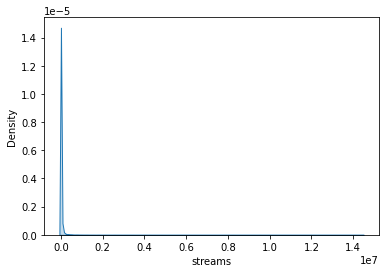

In [42]:
print(
    f'Значения в признаке лежат в пределах от {data_30.streams.min()} до {data_30.streams.max()}')
# посмотрим на распределение значений
snsplot = sns.kdeplot(data_30.streams, shade=True)
fig = snsplot.get_figure()

Разброс значений гигантский (я не стал выводить данные по 14 дням - они распределены аналогично),
их распределение очень нехорошо... НО (!) выбросы удалять нельзя .
Я пробовал определить выбросы и удалить их, и получил негативный результат (более подробно об этом в выводах)

Посмотрим, что будет если целевую переменную прологарифмировать.

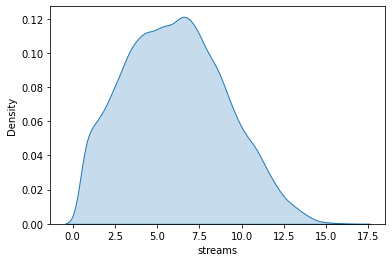

In [43]:
snsplot = sns.kdeplot(np.log(data_30.streams+1), shade=True)
fig = snsplot.get_figure()

С этим уже можно работать. Итак, решено - предсказывать будем логарифмированную переменную.

*логарифмирование признаков не принесло никакого результата, так что не буду здесь тратить время на анализ, но вернусь к вопросу в выводах*

## Обучение модели и получение предикта

На этапе подготовки были проведены испытания разных моделей: CatBoost, RandomForest, XGB, lgbm, TabNet, а также
бэггинг и стэккинг разных моделей. В этом ноутбуке я приведу только работу с CatBoostRegressor, как моделью,
показавшей наилучший результат.

**Важное замечание**.

Стрим сам по себе - очень дешевая штука. Он стоит буквально копейки (около 10 копеек за стрим в лучшем случае),
так что для оценки потенциального релиза не имеет смысла смотреть на точное (до единиц) количество стримов.
Так как вложения в продвижение стрима - это суммы кратные как минимум 5000 рублей, то имеет смысл оценивать
"порядок" предсказанных стримов. Я буду округлять тестовое значение и предсказание до кратного 50000 стримов (то есть 5000 р).

В выводах я остановлюсь на этом чуть подробнее.

Итак, для начала (просто иллюстрация проделанной работы) сделаем предикт на наивной модели. В качестве наивной
буду использовать "простую" линейную регрессию на "заводских" настройках.

**Базовая модель** не работает, если не прологарифмировать признаки (для Catboost делать этого не буду).

In [44]:
# логарифмируем признаки
X = np.log(data_30.drop(['isrc', 'streams'], axis=1)+0.001)
y = data_30.streams
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# логарифмируем целевую переменную в обучающей выборке
y_train_log = np.log(y_train+0.001)
# обучаем baseline модель
baseline = LinearRegression().fit(X_train, y_train_log)

# делаем "логарифмированое" предсказание
y_pred = np.exp(baseline.predict(X_test))//1

# считаем ощибку
mean_absolute_percentage_error(y_test//50000, y_pred//50000)

36.15807767714666

**МАРЕ на базовой модели составляет 36.158%**.

Далее попробуем два варианта предикта. Предсказывать собственно количество стримов и предсказать условный класс трека
(описание классов ниже - когда дойду до классификации). Для предсказания общего количества стримов использовались разные
модели (RandomForest, XGB, lgbm, Catboost), проведены пробы бэггинга и стэккинга. Здесь приведу уже наиболее удачную модель.


### CatBoostRegressor

#### Разбиваем датасет на обучающую и тестовую части

*Для начала выделю тестовую часть, которая не будет использована при настройках модели и будет использована только для контрольной проверки*

In [45]:
X = data_30.drop(['isrc', 'streams'], axis=1)
y = data_30.streams
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

*Теперь уже можно разбить датасет на тренировочный и валидационный*

In [46]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
# логарифмируем целевую переменную в обучающей выборке
y_train_log = np.log(y_train+0.001)

Сначала попробуем Catboost на настройках по умолчанию

In [47]:
# обучаем
reg_cat = CatBoostRegressor()
reg_cat.fit(x_train, y_train_log, verbose=0)

In [48]:
# делаем предикт
y_pred_log = reg_cat.predict(x_valid)
y_pred = np.exp(y_pred_log)
mean_absolute_percentage_error(y_valid//50000, y_pred//50000)

6.879519119381914

MAPE на заводских настройках составляет 6.88%

**Теперь настроим параметры Catboost с помощью OPTUNA**

In [49]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        x_train, y_train_log, test_size=0.2)

    param = {
        "objective": trial.suggest_categorical("objective", ['RMSE', 'MultiRMSE', 'MAE', 'Quantile', 'LogLinQuantile', 'Poisson', 'MAPE']),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostRegressor(**param)

    gbm.fit(train_x, train_y, verbose=0, early_stopping_rounds=100)

    preds_log = gbm.predict(valid_x)//1
    preds = np.exp(preds_log)
    MAPE = mean_absolute_percentage_error(np.exp(valid_y)//1, preds)
    return MAPE


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-11-05 17:10:39,764] A new study created in memory with name: no-name-52254bbe-a38c-4b1c-b114-a4eae15a4093
CatBoost is using more CPU RAM (3.37GiB) than the limit (3GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(123588) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(123588) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(123588) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(123588) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(123588) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(123588) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(123588) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(123588) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(123588) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(

Number of finished trials: 37
Best trial:
  Value: 93.5873794273877
  Params: 
    objective: LogLinQuantile
    colsample_bylevel: 0.07896377360394938
    depth: 10
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 3.0317225474490295


Теперь проверим работу модели с подобранными параметрами на отложенной тестовой выборке.

In [50]:
# Обучаем модель. Параметры подобраны с помощью OPTUNA
reg_cat = CatBoostRegressor(objective='LogLinQuantile',
                            colsample_bylevel=0.07894216202894346,
                            depth=9,
                            boosting_type='Ordered',
                            bootstrap_type='MVS')
reg_cat.fit(x_train, y_train_log, early_stopping_rounds=100, verbose=0)

y_pred_log = reg_cat.predict(X_test)
y_pred = (np.exp(y_pred_log)//1)

mean_absolute_percentage_error(y_test//50000, y_pred//50000)

6.472491909385113

Итак, МАРЕ при задаче сделать предикт на 30 дней - 6.472% (против 6.88, которые были на заводских настройках)
Посмотрим МАРЕ с предсказанием на 14 дней.

In [51]:
X = data_14.drop(['isrc', 'streams'], axis=1)
y = data_14.streams
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# логарифмируем целевую переменную в обучающей выборке
y_train_log = np.log(y_train+0.001)

In [52]:
# Обучаем модель. Параметры подобраны с помощью OPTUNA
reg_cat = CatBoostRegressor(objective='LogLinQuantile',
                            colsample_bylevel=0.07894216202894346,
                            depth=9,
                            boosting_type='Ordered',
                            bootstrap_type='MVS')
reg_cat.fit(X_train, y_train, early_stopping_rounds=100, verbose=0)

y_pred_log = reg_cat.predict(X_test)
y_pred = (np.exp(y_pred_log)//1)

mean_absolute_percentage_error(y_test//50000, y_pred//50000)

4.780817887614004

МАРЕ при предсказании на 14 дней - 4.781%
С Одной стороны - это лучше, чем 6,472% на 30-ти днях, с другой вполне объяснимо, если учесть наше округление
(и опять же вынужден отложить подробности до выводов)

### Посмотрим на значимость признаков

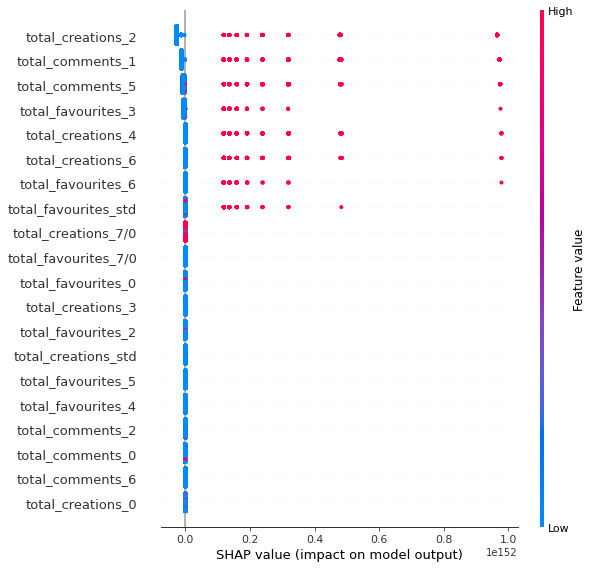

In [53]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(reg_cat)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

Наиболее значимыми оказались средний темп прироста комментариев и показатели сохранений
и комментов на 5,6 и 7 дни после релиза.

Посмотрим на значимость признаков еще одним способом
### Значимость признаков в Catboost

<AxesSubplot:ylabel='feature_names'>

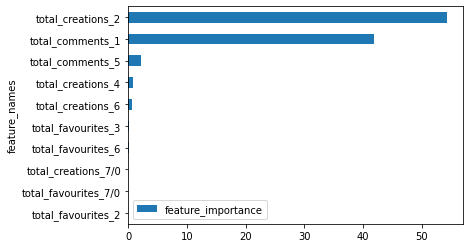

In [54]:
fi = pd.DataFrame({'feature_importance': reg_cat.get_feature_importance(),
                   'feature_names': X_test.columns}).sort_values(by=['feature_importance'],
                                                                 ascending=False)

fi[:10].sort_values(by=['feature_importance'], ascending=True).plot.barh(
    x='feature_names', y='feature_importance')

Видим, что в данном случае наиболее значимы количество видео, снятых на трек в третий день после публикации, комменты на 2 и 6 дни.

## КЛАССИФИКАЦИЯ

Описанное выше показывает, что модель относительно неплохо справляется с задачей,
когда нужно предсказывать не точное значение стримов, а округленное до довольно больших величин. Отсюда вытекает мысль предсказывать
не количество стримов, а класс, к которому можно отнести релиз.

Разобьем все релизы на три класса по количеству собранных за 30 дней стримов (в данном случае рассматривать 14 дней
бессмысленно).Классы такие:
0. loosers - релизы, которые за месяц набрали менее 100000 стримов в ВК (то есть не отобьют за месяц даже 10000р)
1. middling - релизы, которые набрали от 100000 до 500000 стримов в ВК (потенциально могут отбить  до 50000р)
2. good - релизы, которые набрали более 500000 стримов (на которых можно заработать)

Добавлю колонку с классом релиза в датасет

In [55]:
data_30_class = data_30.copy()
data_30_class['stream_class'] = 0

In [56]:
data_30_class.stream_class = data_30_class.streams.apply(lambda x: '0' if x < 50000
                                                        else '1' if x>= 500000 else '2')

Уберем количество стримов (целевая теперь не они!)
и посмотрим на распределение целевой переменной (в нашем случае stream_class)

In [57]:
data_30_class.drop(['streams'], axis = 1, inplace=True)

<AxesSubplot:xlabel='stream_class', ylabel='count'>

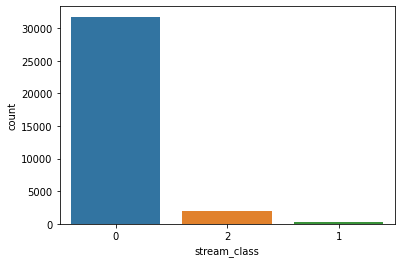

In [58]:
sns.countplot(data_30_class['stream_class'])

У нас чудовищниый перекос в количестве данных. Компенсируем его, применив oversampling.

Но для начала выделим тестовую часть, которую не будем трогать.

In [59]:
X = data_30_class.drop(['isrc', 'stream_class'], axis = 1)
y = data_30_class.stream_class
X_train,X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [60]:
# просто проверю, что в тест попали все классы
y_test.value_counts()

0    6358
2     385
1      55
Name: stream_class, dtype: int64

Вот теперь продолжим работать только с тренировочной частью. Сначала сделаем оверсэмплинг, а потом разобьем
на обучающую и валдиционную часть и прогоним через модель

In [61]:
# отделим тренинговую часть, которую будем оверсэмплить
data_30_for_over = data_30_class[~data_30_class.index.isin(X_test.index)]
data_30_for_over.stream_class.value_counts()

0    25390
2     1564
1      237
Name: stream_class, dtype: int64

Собственно, oversampling

In [62]:
train_0 = data_30_for_over[data_30_for_over.stream_class == '0']
train_1 = data_30_for_over[data_30_for_over.stream_class == '1']
koeff = int((len(train_0)/len(train_1))/2)
for i in range(koeff):
    data_30_for_over = data_30_for_over.append(train_1).reset_index(drop=True)  # объединяем

In [63]:
train_0 = data_30_for_over[data_30_for_over.stream_class == '0']
train_1 = data_30_for_over[data_30_for_over.stream_class == '2']
koeff = int((len(train_0)/len(train_1))/5)
for i in range(koeff):
    data_30_for_over = data_30_for_over.append(train_1).reset_index(drop=True)

<AxesSubplot:xlabel='stream_class', ylabel='count'>

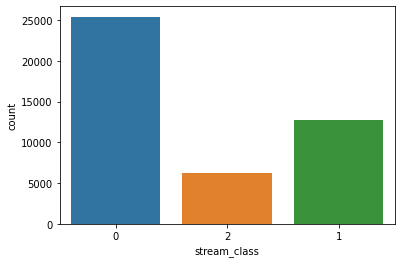

In [64]:
# Посмотрим как теперь с распределением
sns.countplot(data_30_for_over['stream_class'])

In [65]:
data_30_for_over.stream_class.value_counts()

0    25390
1    12798
2     6256
Name: stream_class, dtype: int64

Ну вот! Дисбаланса 10/1 мы избежали. С этой выборкой можно работать

В качестве классификатора лучше всего себя показал **lgbm**, поэтому далее приведу только работу с ним.

### Классификация с LihtGBM

Итак, у нас есть отложенная тестовая выборка, на которой можно будет проверить результат работы.
Оставщуюся тренировочную выборку разбиваем заново на обучающую и валидационную части

In [66]:
X = data_30_for_over.drop(['isrc', 'stream_class'], axis = 1)
y = data_30_for_over.stream_class
X_train,X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [67]:
from lightgbm import LGBMClassifier
# определяем модель
clf = LGBMClassifier()
# обучаем модель
clf.fit(X_train, y_train)

LGBMClassifier()

In [68]:
# делаем предсказание
y_pred = clf.predict(X_valid)

In [69]:
sklearn.metrics.accuracy_score(
    y_valid, y_pred, normalize=True, sample_weight=None)

0.8914388570142873

Итак, точность предсказаний 89,1%. Посмотрим, что можно улучшить, если подобрать параметры с помощью OPTUNA

In [70]:
import optuna.integration.lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


if __name__ == "__main__":
    # data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    data = X
    target = y
    train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y.astype(int))
    dval = lgb.Dataset(val_x, label=val_y.astype(int))

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

    model = lgb.train(
        params, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds=100
    )

    prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
    accuracy = accuracy_score(val_y, prediction)

    best_params = model.params
    print("Best params:", best_params)
    print("  Accuracy = {}".format(accuracy))
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

[I 2021-11-05 17:21:35,069] A new study created in memory with name: no-name-686170fd-4504-491c-bea2-da18fd4971b5
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.260553	valid_1's binary_logloss: 0.285917
[200]	valid_0's binary_logloss: 0.243153	valid_1's binary_logloss: 0.274389
[300]	valid_0's binary_logloss: 0.233877	valid_1's binary_logloss: 0.269091
[400]	valid_0's binary_logloss: 0.227969	valid_1's binary_logloss: 0.265271
[500]	valid_0's binary_logloss: 0.224544	valid_1's binary_logloss: 0.264276
[600]	valid_0's binary_logloss: 0.222026	valid_1's binary_logloss: 0.263938
[700]	valid_0's binary_logloss: 0.219996	valid_1's binary_logloss: 0.263276
[800]	valid_0's binary_logloss: 0.218635	valid_1's binary_logloss: 0.263803


feature_fraction, val_score: 0.263143:  14%|#4        | 1/7 [00:01<00:11,  1.84s/it]

Early stopping, best iteration is:
[711]	valid_0's binary_logloss: 0.219791	valid_1's binary_logloss: 0.263143
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.260813	valid_1's binary_logloss: 0.286786
[200]	valid_0's binary_logloss: 0.243395	valid_1's binary_logloss: 0.274612
[300]	valid_0's binary_logloss: 0.234524	valid_1's binary_logloss: 0.268758
[400]	valid_0's binary_logloss: 0.229282	valid_1's binary_logloss: 0.266167
[500]	valid_0's binary_logloss: 0.225111	valid_1's binary_logloss: 0.263697
[600]	valid_0's binary_logloss: 0.222558	valid_1's binary_logloss: 0.263505
[700]	valid_0's binary_logloss: 0.22062	valid_1's binary_logloss: 0.263327
Early stopping, best iteration is:
[694]	valid_0's binary_logloss: 0.220706	valid_1's binary_logloss: 0.263165


feature_fraction, val_score: 0.263143:  29%|##8       | 2/7 [00:03<00:09,  1.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.262447	valid_1's binary_logloss: 0.286463
[200]	valid_0's binary_logloss: 0.245363	valid_1's binary_logloss: 0.275183
[300]	valid_0's binary_logloss: 0.236333	valid_1's binary_logloss: 0.268962
[400]	valid_0's binary_logloss: 0.230514	valid_1's binary_logloss: 0.265236
[500]	valid_0's binary_logloss: 0.226471	valid_1's binary_logloss: 0.262903
[600]	valid_0's binary_logloss: 0.223505	valid_1's binary_logloss: 0.261464
[700]	valid_0's binary_logloss: 0.221487	valid_1's binary_logloss: 0.261


feature_fraction, val_score: 0.260794:  43%|####2     | 3/7 [00:05<00:06,  1.75s/it]

[800]	valid_0's binary_logloss: 0.219945	valid_1's binary_logloss: 0.261313
Early stopping, best iteration is:
[704]	valid_0's binary_logloss: 0.22138	valid_1's binary_logloss: 0.260794
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.260097	valid_1's binary_logloss: 0.286249
[200]	valid_0's binary_logloss: 0.242523	valid_1's binary_logloss: 0.274403
[300]	valid_0's binary_logloss: 0.23334	valid_1's binary_logloss: 0.26821
[400]	valid_0's binary_logloss: 0.227711	valid_1's binary_logloss: 0.264993
[500]	valid_0's binary_logloss: 0.22435	valid_1's binary_logloss: 0.263989
[600]	valid_0's binary_logloss: 0.221613	valid_1's binary_logloss: 0.263129
[700]	valid_0's binary_logloss: 0.220005	valid_1's binary_logloss: 0.263943


feature_fraction, val_score: 0.260794:  57%|#####7    | 4/7 [00:07<00:05,  1.76s/it]

Early stopping, best iteration is:
[633]	valid_0's binary_logloss: 0.220922	valid_1's binary_logloss: 0.262895
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.259632	valid_1's binary_logloss: 0.286189
[200]	valid_0's binary_logloss: 0.24221	valid_1's binary_logloss: 0.273723
[300]	valid_0's binary_logloss: 0.233196	valid_1's binary_logloss: 0.267785
[400]	valid_0's binary_logloss: 0.227633	valid_1's binary_logloss: 0.26513
[500]	valid_0's binary_logloss: 0.224062	valid_1's binary_logloss: 0.264382


feature_fraction, val_score: 0.260794:  71%|#######1  | 5/7 [00:08<00:03,  1.77s/it]

[600]	valid_0's binary_logloss: 0.221611	valid_1's binary_logloss: 0.264284
Early stopping, best iteration is:
[567]	valid_0's binary_logloss: 0.222203	valid_1's binary_logloss: 0.263714
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.260972	valid_1's binary_logloss: 0.286633
[200]	valid_0's binary_logloss: 0.243378	valid_1's binary_logloss: 0.274737
[300]	valid_0's binary_logloss: 0.23403	valid_1's binary_logloss: 0.268729
[400]	valid_0's binary_logloss: 0.228435	valid_1's binary_logloss: 0.265054
[500]	valid_0's binary_logloss: 0.224786	valid_1's binary_logloss: 0.263701
[600]	valid_0's binary_logloss: 0.222233	valid_1's binary_logloss: 0.263447


feature_fraction, val_score: 0.260794:  86%|########5 | 6/7 [00:10<00:01,  1.78s/it]

[700]	valid_0's binary_logloss: 0.220182	valid_1's binary_logloss: 0.263405
Early stopping, best iteration is:
[645]	valid_0's binary_logloss: 0.221125	valid_1's binary_logloss: 0.263009
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.262238	valid_1's binary_logloss: 0.28778
[200]	valid_0's binary_logloss: 0.244362	valid_1's binary_logloss: 0.274674
[300]	valid_0's binary_logloss: 0.235106	valid_1's binary_logloss: 0.268391
[400]	valid_0's binary_logloss: 0.229328	valid_1's binary_logloss: 0.264566
[500]	valid_0's binary_logloss: 0.225499	valid_1's binary_logloss: 0.263596
[600]	valid_0's binary_logloss: 0.222998	valid_1's binary_logloss: 0.263167
[700]	valid_0's binary_logloss: 0.221013	valid_1's binary_logloss: 0.262543


num_leaves, val_score: 0.260794:   0%|          | 0/20 [00:00<?, ?it/s]

[800]	valid_0's binary_logloss: 0.219483	valid_1's binary_logloss: 0.262584
Early stopping, best iteration is:
[739]	valid_0's binary_logloss: 0.220294	valid_1's binary_logloss: 0.262263
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.307144	valid_1's binary_logloss: 0.318301
[200]	valid_0's binary_logloss: 0.294959	valid_1's binary_logloss: 0.307925
[300]	valid_0's binary_logloss: 0.287567	valid_1's binary_logloss: 0.302596
[400]	valid_0's binary_logloss: 0.281996	valid_1's binary_logloss: 0.298453
[500]	valid_0's binary_logloss: 0.276965	valid_1's binary_logloss: 0.294897
[600]	valid_0's binary_logloss: 0.272774	valid_1's binary_logloss: 0.292306
[700]	valid_0's binary_logloss: 0.269353	valid_1's binary_logloss: 0.290335
[800]	valid_0's binary_logloss: 0.266543	valid_1's binary_logloss: 0.288767


num_leaves, val_score: 0.260794:   5%|5         | 1/20 [00:01<00:19,  1.05s/it]

[900]	valid_0's binary_logloss: 0.263936	valid_1's binary_logloss: 0.28697
[1000]	valid_0's binary_logloss: 0.261431	valid_1's binary_logloss: 0.285361
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.261431	valid_1's binary_logloss: 0.285361
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.22392	valid_1's binary_logloss: 0.257014
[200]	valid_0's binary_logloss: 0.216994	valid_1's binary_logloss: 0.260609
Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.221495	valid_1's binary_logloss: 0.256967


num_leaves, val_score: 0.256967:  10%|#         | 2/20 [00:03<00:31,  1.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.22383	valid_1's binary_logloss: 0.257268


num_leaves, val_score: 0.256941:  15%|#5        | 3/20 [00:05<00:31,  1.86s/it]

[200]	valid_0's binary_logloss: 0.216974	valid_1's binary_logloss: 0.261347
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.2231	valid_1's binary_logloss: 0.256941
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.260291	valid_1's binary_logloss: 0.285494
[200]	valid_0's binary_logloss: 0.243585	valid_1's binary_logloss: 0.274422
[300]	valid_0's binary_logloss: 0.234672	valid_1's binary_logloss: 0.268536
[400]	valid_0's binary_logloss: 0.229259	valid_1's binary_logloss: 0.265681
[500]	valid_0's binary_logloss: 0.225574	valid_1's binary_logloss: 0.264581
[600]	valid_0's binary_logloss: 0.222801	valid_1's binary_logloss: 0.263219
[700]	valid_0's binary_logloss: 0.220797	valid_1's binary_logloss: 0.262863


num_leaves, val_score: 0.256941:  20%|##        | 4/20 [00:07<00:29,  1.87s/it]

Early stopping, best iteration is:
[679]	valid_0's binary_logloss: 0.221077	valid_1's binary_logloss: 0.26257
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.22628	valid_1's binary_logloss: 0.259541
[200]	valid_0's binary_logloss: 0.217706	valid_1's binary_logloss: 0.258694


num_leaves, val_score: 0.256941:  25%|##5       | 5/20 [00:09<00:28,  1.92s/it]

Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.219221	valid_1's binary_logloss: 0.257554
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.293255	valid_1's binary_logloss: 0.307139
[200]	valid_0's binary_logloss: 0.277922	valid_1's binary_logloss: 0.296106
[300]	valid_0's binary_logloss: 0.268768	valid_1's binary_logloss: 0.29013
[400]	valid_0's binary_logloss: 0.262174	valid_1's binary_logloss: 0.28577
[500]	valid_0's binary_logloss: 0.256841	valid_1's binary_logloss: 0.282095
[600]	valid_0's binary_logloss: 0.252329	valid_1's binary_logloss: 0.279279
[700]	valid_0's binary_logloss: 0.249129	valid_1's binary_logloss: 0.277544
[800]	valid_0's binary_logloss: 0.24566	valid_1's binary_logloss: 0.275104
[900]	valid_0's binary_logloss: 0.242941	valid_1's binary_logloss: 0.273252


num_leaves, val_score: 0.256941:  30%|###       | 6/20 [00:10<00:23,  1.69s/it]

[1000]	valid_0's binary_logloss: 0.240805	valid_1's binary_logloss: 0.272337
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.240805	valid_1's binary_logloss: 0.272337
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.270021	valid_1's binary_logloss: 0.291903
[200]	valid_0's binary_logloss: 0.253352	valid_1's binary_logloss: 0.281352
[300]	valid_0's binary_logloss: 0.243335	valid_1's binary_logloss: 0.274162
[400]	valid_0's binary_logloss: 0.236656	valid_1's binary_logloss: 0.269437
[500]	valid_0's binary_logloss: 0.232221	valid_1's binary_logloss: 0.265979
[600]	valid_0's binary_logloss: 0.228947	valid_1's binary_logloss: 0.264592
[700]	valid_0's binary_logloss: 0.226495	valid_1's binary_logloss: 0.263843
[800]	valid_0's binary_logloss: 0.224326	valid_1's binary_logloss: 0.263565
[900]	valid_0's binary_logloss: 0.222649	valid_1's binary_logloss: 0.263459


num_leaves, val_score: 0.256941:  35%|###5      | 7/20 [00:12<00:23,  1.84s/it]

[1000]	valid_0's binary_logloss: 0.221126	valid_1's binary_logloss: 0.262808
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.221126	valid_1's binary_logloss: 0.262808
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.278213	valid_1's binary_logloss: 0.297061
[200]	valid_0's binary_logloss: 0.26119	valid_1's binary_logloss: 0.285773
[300]	valid_0's binary_logloss: 0.251308	valid_1's binary_logloss: 0.279644
[400]	valid_0's binary_logloss: 0.244102	valid_1's binary_logloss: 0.275089
[500]	valid_0's binary_logloss: 0.239229	valid_1's binary_logloss: 0.271364
[600]	valid_0's binary_logloss: 0.235435	valid_1's binary_logloss: 0.269189
[700]	valid_0's binary_logloss: 0.232652	valid_1's binary_logloss: 0.267676
[800]	valid_0's binary_logloss: 0.22983	valid_1's binary_logloss: 0.265695


num_leaves, val_score: 0.256941:  40%|####      | 8/20 [00:14<00:22,  1.83s/it][I 2021-11-05 17:22:02,180] Trial 14 finished with value: 0.2646665257898404 and parameters: {'num_leaves': 17}. Best is trial 9 with value: 0.25694069367198324.


[900]	valid_0's binary_logloss: 0.227833	valid_1's binary_logloss: 0.26513
[1000]	valid_0's binary_logloss: 0.226224	valid_1's binary_logloss: 0.264667
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.226224	valid_1's binary_logloss: 0.264667


num_leaves, val_score: 0.256941:  40%|####      | 8/20 [00:14<00:22,  1.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.223975	valid_1's binary_logloss: 0.257164
[200]	valid_0's binary_logloss: 0.217009	valid_1's binary_logloss: 0.260626


num_leaves, val_score: 0.256941:  45%|####5     | 9/20 [00:16<00:21,  1.94s/it]

Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.2209	valid_1's binary_logloss: 0.256993
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.268991	valid_1's binary_logloss: 0.290606
[200]	valid_0's binary_logloss: 0.251747	valid_1's binary_logloss: 0.280154
[300]	valid_0's binary_logloss: 0.242308	valid_1's binary_logloss: 0.273455
[400]	valid_0's binary_logloss: 0.235556	valid_1's binary_logloss: 0.268092
[500]	valid_0's binary_logloss: 0.231077	valid_1's binary_logloss: 0.265973
[600]	valid_0's binary_logloss: 0.228024	valid_1's binary_logloss: 0.265081
[700]	valid_0's binary_logloss: 0.225675	valid_1's binary_logloss: 0.264319
[800]	valid_0's binary_logloss: 0.223658	valid_1's binary_logloss: 0.26366
[900]	valid_0's binary_logloss: 0.222129	valid_1's binary_logloss: 0.263473


num_leaves, val_score: 0.256941:  50%|#####     | 10/20 [00:19<00:21,  2.13s/it]

[1000]	valid_0's binary_logloss: 0.220874	valid_1's binary_logloss: 0.263443
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.220874	valid_1's binary_logloss: 0.263443
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.233747	valid_1's binary_logloss: 0.266111
[200]	valid_0's binary_logloss: 0.221817	valid_1's binary_logloss: 0.259771
[300]	valid_0's binary_logloss: 0.217566	valid_1's binary_logloss: 0.25969
Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.219727	valid_1's binary_logloss: 0.258445


num_leaves, val_score: 0.256941:  55%|#####5    | 11/20 [00:20<00:18,  2.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.223819	valid_1's binary_logloss: 0.25754


num_leaves, val_score: 0.256941:  60%|######    | 12/20 [00:23<00:16,  2.07s/it]

[200]	valid_0's binary_logloss: 0.216953	valid_1's binary_logloss: 0.262833
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.22244	valid_1's binary_logloss: 0.257444
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.224544	valid_1's binary_logloss: 0.258577
[200]	valid_0's binary_logloss: 0.217152	valid_1's binary_logloss: 0.260319


num_leaves, val_score: 0.256941:  65%|######5   | 13/20 [00:25<00:14,  2.06s/it]

Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.220332	valid_1's binary_logloss: 0.257622
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.2245	valid_1's binary_logloss: 0.257577
[200]	valid_0's binary_logloss: 0.217084	valid_1's binary_logloss: 0.261046
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.221267	valid_1's binary_logloss: 0.25704


num_leaves, val_score: 0.256941:  70%|#######   | 14/20 [00:27<00:12,  2.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.23169	valid_1's binary_logloss: 0.264403
[200]	valid_0's binary_logloss: 0.220316	valid_1's binary_logloss: 0.257947


num_leaves, val_score: 0.256941:  75%|#######5  | 15/20 [00:28<00:09,  1.96s/it]

Early stopping, best iteration is:
[198]	valid_0's binary_logloss: 0.220389	valid_1's binary_logloss: 0.257923
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.226394	valid_1's binary_logloss: 0.259108
[200]	valid_0's binary_logloss: 0.21777	valid_1's binary_logloss: 0.257535


num_leaves, val_score: 0.256623:  80%|########  | 16/20 [00:30<00:07,  1.96s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.219316	valid_1's binary_logloss: 0.256623
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.227282	valid_1's binary_logloss: 0.260523
[200]	valid_0's binary_logloss: 0.218123	valid_1's binary_logloss: 0.258778


num_leaves, val_score: 0.256623:  85%|########5 | 17/20 [00:32<00:05,  1.95s/it]

Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.219703	valid_1's binary_logloss: 0.257814
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.235961	valid_1's binary_logloss: 0.268536
[200]	valid_0's binary_logloss: 0.223455	valid_1's binary_logloss: 0.26153
[300]	valid_0's binary_logloss: 0.218616	valid_1's binary_logloss: 0.261213
Early stopping, best iteration is:
[233]	valid_0's binary_logloss: 0.221226	valid_1's binary_logloss: 0.260488


num_leaves, val_score: 0.256623:  90%|######### | 18/20 [00:34<00:03,  1.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.242495	valid_1's binary_logloss: 0.273146
[200]	valid_0's binary_logloss: 0.227832	valid_1's binary_logloss: 0.263445
[300]	valid_0's binary_logloss: 0.221674	valid_1's binary_logloss: 0.260525
[400]	valid_0's binary_logloss: 0.218563	valid_1's binary_logloss: 0.260609
Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.220375	valid_1's binary_logloss: 0.259786


num_leaves, val_score: 0.256623:  95%|#########5| 19/20 [00:36<00:01,  1.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.227601	valid_1's binary_logloss: 0.260484
[200]	valid_0's binary_logloss: 0.218311	valid_1's binary_logloss: 0.257909


bagging, val_score: 0.256623:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[172]	valid_0's binary_logloss: 0.219691	valid_1's binary_logloss: 0.257437
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.226793	valid_1's binary_logloss: 0.259162
[200]	valid_0's binary_logloss: 0.217909	valid_1's binary_logloss: 0.258488


bagging, val_score: 0.256623:  10%|#         | 1/10 [00:01<00:16,  1.81s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.221359	valid_1's binary_logloss: 0.257117
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.23002	valid_1's binary_logloss: 0.26382
[200]	valid_0's binary_logloss: 0.219611	valid_1's binary_logloss: 0.260331


bagging, val_score: 0.256623:  20%|##        | 2/10 [00:03<00:14,  1.84s/it]

Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.221501	valid_1's binary_logloss: 0.259982
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.236238	valid_1's binary_logloss: 0.269266
[200]	valid_0's binary_logloss: 0.22339	valid_1's binary_logloss: 0.268651


bagging, val_score: 0.256623:  30%|###       | 3/10 [00:05<00:12,  1.76s/it]

Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.227425	valid_1's binary_logloss: 0.265409
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.232118	valid_1's binary_logloss: 0.265565
[200]	valid_0's binary_logloss: 0.220952	valid_1's binary_logloss: 0.263954


bagging, val_score: 0.256623:  40%|####      | 4/10 [00:07<00:10,  1.82s/it]

Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.222301	valid_1's binary_logloss: 0.262944
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.239581	valid_1's binary_logloss: 0.27217
[200]	valid_0's binary_logloss: 0.555237	valid_1's binary_logloss: 0.641546


bagging, val_score: 0.256623:  50%|#####     | 5/10 [00:08<00:08,  1.73s/it]

Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.229647	valid_1's binary_logloss: 0.268713
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.227116	valid_1's binary_logloss: 0.26008
[200]	valid_0's binary_logloss: 0.218078	valid_1's binary_logloss: 0.259084


bagging, val_score: 0.256623:  60%|######    | 6/10 [00:10<00:07,  1.81s/it]

Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.220658	valid_1's binary_logloss: 0.257557
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.227472	valid_1's binary_logloss: 0.260538
[200]	valid_0's binary_logloss: 0.218339	valid_1's binary_logloss: 0.259273


bagging, val_score: 0.256623:  70%|#######   | 7/10 [00:12<00:05,  1.82s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.221951	valid_1's binary_logloss: 0.258275
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.233064	valid_1's binary_logloss: 0.266039
[200]	valid_0's binary_logloss: 0.221605	valid_1's binary_logloss: 0.266169


bagging, val_score: 0.256623:  80%|########  | 8/10 [00:14<00:03,  1.80s/it]

Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.22678	valid_1's binary_logloss: 0.263419
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.226605	valid_1's binary_logloss: 0.259426
[200]	valid_0's binary_logloss: 0.21775	valid_1's binary_logloss: 0.259145


bagging, val_score: 0.256623:  90%|######### | 9/10 [00:16<00:01,  1.87s/it]

Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.221657	valid_1's binary_logloss: 0.257481
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.227342	valid_1's binary_logloss: 0.260933
[200]	valid_0's binary_logloss: 0.218373	valid_1's binary_logloss: 0.259432


feature_fraction_stage2, val_score: 0.256623:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.220186	valid_1's binary_logloss: 0.25822
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.225944	valid_1's binary_logloss: 0.259536
[200]	valid_0's binary_logloss: 0.217658	valid_1's binary_logloss: 0.258687


feature_fraction_stage2, val_score: 0.256623:  33%|###3      | 1/3 [00:02<00:04,  2.08s/it]

Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.220173	valid_1's binary_logloss: 0.257575
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.225789	valid_1's binary_logloss: 0.260995
[200]	valid_0's binary_logloss: 0.217429	valid_1's binary_logloss: 0.260641


feature_fraction_stage2, val_score: 0.256623:  67%|######6   | 2/3 [00:04<00:02,  2.21s/it]

Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 0.219275	valid_1's binary_logloss: 0.25881
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.225363	valid_1's binary_logloss: 0.259498
[200]	valid_0's binary_logloss: 0.217372	valid_1's binary_logloss: 0.258837


regularization_factors, val_score: 0.256623:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.219294	valid_1's binary_logloss: 0.257488
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.229405	valid_1's binary_logloss: 0.260384
[200]	valid_0's binary_logloss: 0.221907	valid_1's binary_logloss: 0.25629
[300]	valid_0's binary_logloss: 0.220186	valid_1's binary_logloss: 0.255799
[400]	valid_0's binary_logloss: 0.219604	valid_1's binary_logloss: 0.255814


regularization_factors, val_score: 0.255764:   5%|5         | 1/20 [00:02<00:51,  2.72s/it]

Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.219654	valid_1's binary_logloss: 0.255764
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.254623	valid_1's binary_logloss: 0.280066


regularization_factors, val_score: 0.255764:  10%|#         | 2/20 [00:03<00:31,  1.76s/it]

[200]	valid_0's binary_logloss: 0.247769	valid_1's binary_logloss: 0.275747
[300]	valid_0's binary_logloss: 0.247333	valid_1's binary_logloss: 0.275415
Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.247334	valid_1's binary_logloss: 0.275411
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.226488	valid_1's binary_logloss: 0.259451
[200]	valid_0's binary_logloss: 0.217751	valid_1's binary_logloss: 0.258177


regularization_factors, val_score: 0.255764:  15%|#5        | 3/20 [00:06<00:39,  2.33s/it]

Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.219158	valid_1's binary_logloss: 0.257283
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.226479	valid_1's binary_logloss: 0.26075
[200]	valid_0's binary_logloss: 0.217822	valid_1's binary_logloss: 0.25909


regularization_factors, val_score: 0.255764:  20%|##        | 4/20 [00:09<00:38,  2.38s/it]

Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.219579	valid_1's binary_logloss: 0.258224
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.240469	valid_1's binary_logloss: 0.269007
[200]	valid_0's binary_logloss: 0.233455	valid_1's binary_logloss: 0.264361


regularization_factors, val_score: 0.255764:  25%|##5       | 5/20 [00:10<00:31,  2.08s/it]

[300]	valid_0's binary_logloss: 0.231809	valid_1's binary_logloss: 0.263299
[400]	valid_0's binary_logloss: 0.231774	valid_1's binary_logloss: 0.263302
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.231779	valid_1's binary_logloss: 0.26329
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.268544	valid_1's binary_logloss: 0.289228


regularization_factors, val_score: 0.255764:  30%|###       | 6/20 [00:11<00:23,  1.71s/it]

[200]	valid_0's binary_logloss: 0.262252	valid_1's binary_logloss: 0.285213
[300]	valid_0's binary_logloss: 0.261915	valid_1's binary_logloss: 0.284978
[400]	valid_0's binary_logloss: 0.261887	valid_1's binary_logloss: 0.284955
Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.261887	valid_1's binary_logloss: 0.284955


[I 2021-11-05 17:23:03,204] Trial 45 finished with value: 0.28495537489357 and parameters: {'lambda_l1': 6.093816124456822, 'lambda_l2': 8.152190312493006e-05}. Best is trial 40 with value: 0.2557635070159214.
regularization_factors, val_score: 0.255764:  30%|###       | 6/20 [00:11<00:23,  1.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.248185	valid_1's binary_logloss: 0.275045
[200]	valid_0's binary_logloss: 0.233817	valid_1's binary_logloss: 0.264929
[300]	valid_0's binary_logloss: 0.228055	valid_1's binary_logloss: 0.260762
[400]	valid_0's binary_logloss: 0.225026	valid_1's binary_logloss: 0.258718
[500]	valid_0's binary_logloss: 0.22311	valid_1's binary_logloss: 0.257693
[600]	valid_0's binary_logloss: 0.221785	valid_1's binary_logloss: 0.257174
[700]	valid_0's binary_logloss: 0.220833	valid_1's binary_logloss: 0.256847
[800]	valid_0's binary_logloss: 0.22013	valid_1's binary_logloss: 0.256803
[900]	valid_0's binary_logloss: 0.219577	valid_1's binary_logloss: 0.25677
[1000]	valid_0's binary_logloss: 0.219103	valid_1's binary_logloss: 0.256827
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.219103	valid_1's binary_logloss: 0.256827


regularization_factors, val_score: 0.255764:  35%|###5      | 7/20 [00:19<00:48,  3.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.230573	valid_1's binary_logloss: 0.260322
[200]	valid_0's binary_logloss: 0.223245	valid_1's binary_logloss: 0.256195
[300]	valid_0's binary_logloss: 0.221467	valid_1's binary_logloss: 0.255571
[400]	valid_0's binary_logloss: 0.220954	valid_1's binary_logloss: 0.255407
Early stopping, best iteration is:
[364]	valid_0's binary_logloss: 0.2211	valid_1's binary_logloss: 0.25539


regularization_factors, val_score: 0.255390:  40%|####      | 8/20 [00:22<00:39,  3.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.226178	valid_1's binary_logloss: 0.259357
[200]	valid_0's binary_logloss: 0.2178	valid_1's binary_logloss: 0.257651


regularization_factors, val_score: 0.255390:  45%|####5     | 9/20 [00:24<00:33,  3.01s/it]

Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.219196	valid_1's binary_logloss: 0.257165
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.22654	valid_1's binary_logloss: 0.260292
[200]	valid_0's binary_logloss: 0.21776	valid_1's binary_logloss: 0.258514


regularization_factors, val_score: 0.255390:  50%|#####     | 10/20 [00:26<00:27,  2.77s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.219314	valid_1's binary_logloss: 0.257288
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.226498	valid_1's binary_logloss: 0.259358
[200]	valid_0's binary_logloss: 0.21785	valid_1's binary_logloss: 0.257086


regularization_factors, val_score: 0.255390:  55%|#####5    | 11/20 [00:29<00:23,  2.65s/it]

Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.219205	valid_1's binary_logloss: 0.256404
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.227676	valid_1's binary_logloss: 0.259214
[200]	valid_0's binary_logloss: 0.21927	valid_1's binary_logloss: 0.255198


regularization_factors, val_score: 0.255088:  60%|######    | 12/20 [00:31<00:20,  2.53s/it]

Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 0.219815	valid_1's binary_logloss: 0.255088
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.231041	valid_1's binary_logloss: 0.261482
[200]	valid_0's binary_logloss: 0.221789	valid_1's binary_logloss: 0.255707
[300]	valid_0's binary_logloss: 0.219045	valid_1's binary_logloss: 0.255065


regularization_factors, val_score: 0.255049:  65%|######5   | 13/20 [00:34<00:18,  2.65s/it]

Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.21927	valid_1's binary_logloss: 0.255049
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.230405	valid_1's binary_logloss: 0.261769
[200]	valid_0's binary_logloss: 0.221134	valid_1's binary_logloss: 0.256074
[300]	valid_0's binary_logloss: 0.21841	valid_1's binary_logloss: 0.256275
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.220259	valid_1's binary_logloss: 0.255833


regularization_factors, val_score: 0.255049:  70%|#######   | 14/20 [00:36<00:15,  2.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.227081	valid_1's binary_logloss: 0.258474
[200]	valid_0's binary_logloss: 0.218612	valid_1's binary_logloss: 0.25553


regularization_factors, val_score: 0.255049:  75%|#######5  | 15/20 [00:39<00:12,  2.52s/it]

Early stopping, best iteration is:
[184]	valid_0's binary_logloss: 0.219217	valid_1's binary_logloss: 0.255339
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.226931	valid_1's binary_logloss: 0.259368
[200]	valid_0's binary_logloss: 0.21854	valid_1's binary_logloss: 0.256111


regularization_factors, val_score: 0.255049:  80%|########  | 16/20 [00:41<00:09,  2.37s/it]

Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.220018	valid_1's binary_logloss: 0.255648
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.230559	valid_1's binary_logloss: 0.26131
[200]	valid_0's binary_logloss: 0.221352	valid_1's binary_logloss: 0.256143
[300]	valid_0's binary_logloss: 0.218533	valid_1's binary_logloss: 0.256168


regularization_factors, val_score: 0.255049:  85%|########5 | 17/20 [00:43<00:07,  2.44s/it]

Early stopping, best iteration is:
[233]	valid_0's binary_logloss: 0.220116	valid_1's binary_logloss: 0.255928
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.249008	valid_1's binary_logloss: 0.27555
[200]	valid_0's binary_logloss: 0.234537	valid_1's binary_logloss: 0.265375
[300]	valid_0's binary_logloss: 0.228631	valid_1's binary_logloss: 0.261204
[400]	valid_0's binary_logloss: 0.225524	valid_1's binary_logloss: 0.259014
[500]	valid_0's binary_logloss: 0.223577	valid_1's binary_logloss: 0.257851
[600]	valid_0's binary_logloss: 0.222186	valid_1's binary_logloss: 0.257156
[700]	valid_0's binary_logloss: 0.221196	valid_1's binary_logloss: 0.256682
[800]	valid_0's binary_logloss: 0.220452	valid_1's binary_logloss: 0.256498
[900]	valid_0's binary_logloss: 0.219874	valid_1's binary_logloss: 0.256453
[1000]	valid_0's binary_logloss: 0.219369	valid_1's binary_logloss: 0.256463
Did not meet early stopping. Best iteration is:
[1000]	valid_0's bi

regularization_factors, val_score: 0.255049:  90%|######### | 18/20 [00:50<00:07,  3.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.230041	valid_1's binary_logloss: 0.261426
[200]	valid_0's binary_logloss: 0.221209	valid_1's binary_logloss: 0.256669
[300]	valid_0's binary_logloss: 0.218727	valid_1's binary_logloss: 0.256262


regularization_factors, val_score: 0.255049:  95%|#########5| 19/20 [00:53<00:03,  3.60s/it]

[400]	valid_0's binary_logloss: 0.217742	valid_1's binary_logloss: 0.256899
Early stopping, best iteration is:
[305]	valid_0's binary_logloss: 0.218676	valid_1's binary_logloss: 0.256187
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.226761	valid_1's binary_logloss: 0.260498
[200]	valid_0's binary_logloss: 0.218098	valid_1's binary_logloss: 0.258287


min_data_in_leaf, val_score: 0.255049:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 0.220141	valid_1's binary_logloss: 0.257674
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.242239	valid_1's binary_logloss: 0.270997
[200]	valid_0's binary_logloss: 0.228763	valid_1's binary_logloss: 0.262551
[300]	valid_0's binary_logloss: 0.223678	valid_1's binary_logloss: 0.259784
[400]	valid_0's binary_logloss: 0.221215	valid_1's binary_logloss: 0.259232
[500]	valid_0's binary_logloss: 0.219769	valid_1's binary_logloss: 0.259213
Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.22092	valid_1's binary_logloss: 0.259096


min_data_in_leaf, val_score: 0.255049:  20%|##        | 1/5 [00:03<00:13,  3.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.227208	valid_1's binary_logloss: 0.259392
[200]	valid_0's binary_logloss: 0.219737	valid_1's binary_logloss: 0.254446
[300]	valid_0's binary_logloss: 0.217752	valid_1's binary_logloss: 0.254722
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.219078	valid_1's binary_logloss: 0.254289


min_data_in_leaf, val_score: 0.254289:  40%|####      | 2/5 [00:06<00:09,  3.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.256588	valid_1's binary_logloss: 0.281527
[200]	valid_0's binary_logloss: 0.240483	valid_1's binary_logloss: 0.27258
[300]	valid_0's binary_logloss: 0.232983	valid_1's binary_logloss: 0.267924
[400]	valid_0's binary_logloss: 0.228758	valid_1's binary_logloss: 0.265451
[500]	valid_0's binary_logloss: 0.225988	valid_1's binary_logloss: 0.264403
[600]	valid_0's binary_logloss: 0.22403	valid_1's binary_logloss: 0.263885
[700]	valid_0's binary_logloss: 0.222666	valid_1's binary_logloss: 0.26375


min_data_in_leaf, val_score: 0.254289:  60%|######    | 3/5 [00:11<00:08,  4.28s/it]

Early stopping, best iteration is:
[670]	valid_0's binary_logloss: 0.223017	valid_1's binary_logloss: 0.263639
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.228161	valid_1's binary_logloss: 0.260109
[200]	valid_0's binary_logloss: 0.220245	valid_1's binary_logloss: 0.25521
[300]	valid_0's binary_logloss: 0.218072	valid_1's binary_logloss: 0.255318
Early stopping, best iteration is:
[223]	valid_0's binary_logloss: 0.219536	valid_1's binary_logloss: 0.255136


min_data_in_leaf, val_score: 0.254289:  80%|########  | 4/5 [00:15<00:04,  4.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.232895	valid_1's binary_logloss: 0.262676
[200]	valid_0's binary_logloss: 0.222855	valid_1's binary_logloss: 0.25676
[300]	valid_0's binary_logloss: 0.219738	valid_1's binary_logloss: 0.256107
[400]	valid_0's binary_logloss: 0.218361	valid_1's binary_logloss: 0.256396
Early stopping, best iteration is:
[316]	valid_0's binary_logloss: 0.219462	valid_1's binary_logloss: 0.256067


min_data_in_leaf, val_score: 0.254289: 100%|##########| 5/5 [00:20<00:00,  4.15s/it]

Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.0775690870868683, 'lambda_l2': 0.8636237607151321, 'num_leaves': 167, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
  Accuracy = 0.0
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.0775690870868683
    lambda_l2: 0.8636237607151321
    num_leaves: 167
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


Попробуем подобранные параметры применить

In [71]:
# определяем модель с параметрами
clf = LGBMClassifier(objective = 'binary',
                    verbosity = -1,
                    boosting_type = 'gbdt',
                    feature_pre_filter = False,
                    lambda_l1 = 1.0257520070246593e-07,
                    lambda_l2 = 1.0141866856486015e-08,
                    num_leaves = 246,
                    feature_fraction = 0.8,
                    bagging_fraction = 1.0,
                    bagging_freq = 0,
                    min_child_samples = 5)
# обучаем модель
clf.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.8,
               feature_pre_filter=False, lambda_l1=1.0257520070246593e-07,
               lambda_l2=1.0141866856486015e-08, min_child_samples=5,
               num_leaves=246, objective='binary', verbosity=-1)

In [72]:
# делаем предикт
y_pred = clf.predict(X_valid)
sklearn.metrics.accuracy_score(
    y_valid, y_pred, normalize=True, sample_weight=None)

0.9095511306108673

Метрика немного улучшилась и стала **91%**

Теперь попробуем как это будет работать на отложенной тестовой выборке

In [73]:
y_pred = clf.predict(X_test)
sklearn.metrics.accuracy_score(
    y_test, y_pred, normalize=True, sample_weight=None)

0.951309208590762

Попробую оценить важность признаков в lgbm

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

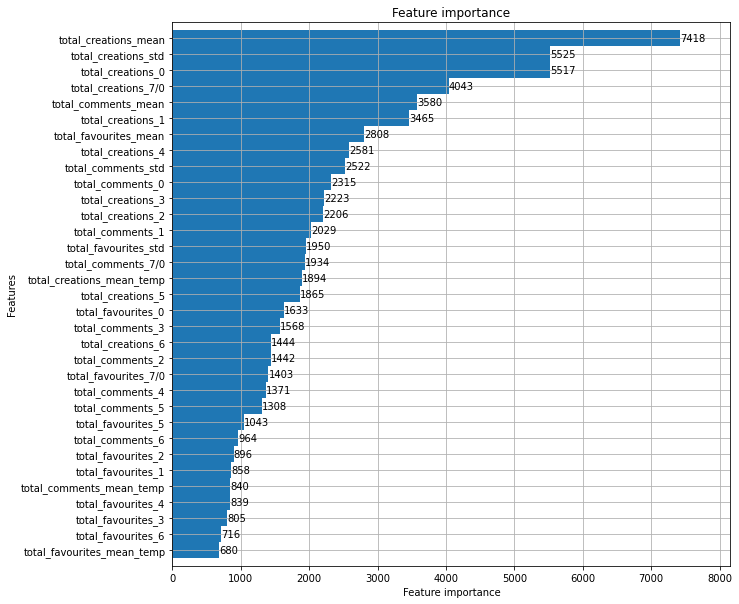

In [74]:
# Теперь посмотрим на важные признаки
lightgbm.plot_importance(clf, height=1, figsize=(10,10))

Точность предсказаний классов с настроенным lgbm - **95,13%**
*По классам предсказания распределились так: loosers: в тесте было 6358, в предикте - 6438; middlers: в тесте - 55, в предикте - 42; good: в тесте - 385, в предикте - 318*
То есть lgbm занижает результаты так же как и catboosregressor, но теперь уверенно предсказывает не только 0 :)


Наиболее важными стали признаки total_creations_mean (среднее к-во созданных видео), стандартное отклонение в
ряду созданных видео, видео, которые были созданы в первый день публикации трека и соотношение видео,
созданных в последний и первый день. Куда более оправданные параметры с точки зрения опыта.

## ОБЩИЕ ВЫВОДЫ

### Главное
Итак, для работы я бы использовал в итоге **классификацию lgbm**, учитывая, что предсказывая "точное" количество
стримов, мы все равно фактически предсказывали очень огрубленные классы. С экономической точки зрения
использование именно классов тоже важнее, чем точное количество стримов.

### Негатив
Внимательно проализировав полученные предикты, я понимаю, что модель предсказания точного количества стримов работает очень грязно и
отлично предсказывает только нули (то есть релизы, которые не доберутся даже до 50000 стримов за 14 или 30 дней), а
вот предсказания большого количества стримов модель делает плохо. Собственно, это объяснимо.
Мы обучали модель на данных, где подавляющее количество стримов (целевая переменная) мало, а большие стримы
(мечта каждого издательства) фактически являются выбросами. Но (!) если их удалить, то останется только "лузерская" часть
релизов и машина прекрасно обучится "детализировать" лузеров, но какой в этом прок?

Модель, предсказывающая классы работает значительно лучше, но классов, которые она может предсказать,
маловато. А увеличение классов почти невозможно из-за небольшого количества данных о релизах с большим количеством стримов.


Кроме сказанного выше, видно, что обе модели склонны занижать результаты (то есть давать пессимистический предикт),
что на самом деле не так и плохо с экономической точки зрения, так как позволит избежать большого количества
"невозвратных" вложений.

### Позитив
Итак, пользуясь результатами этой работы, можно "рамочно" определить количество стримов,
которые может набрать потенциальный релиз за 14 или 30 дней после публикации. Это очень хорошо,
так как до сих пор (как это ни удивительно) нет никаких объективных инструментов для оценки потенциального количества стримов и,
вкладывая деньги в продвижение того или иного трека, инвестор (музыкальное издательство) играет в лотерею.
Благодаря итогам этой работы появилась возможность оценить перспективность вложений в трек
и даже возможность определить потенциальных "звезд". По крайней мере (учитывая раздел с негативом) можно отсеять безусловных "лузеров" и
сэкономить издательству деньги на продвижение откровенно бесперспективных релизов.

### Как улучшить
На мой взгляд предикты этой модели значительно улучшаться по прошествии пары лет. Во-первых,
накопится больше фактических данных по релизам (соответственно будет бОльшая база для обучения), а во-вторых (и это главное),
появится бОльшее количество релизов с большим количеством стримов у модели будет возможность обучаться на
более равномерных данных. Временной промежуток можно было бы сократить, получив данные по ВСЕМ релизам, которые выходят в РФ
(я использовал данные только одного издательства), но это представляется очень маловероятным, в силу
отношений между игроками рынка.
